In [29]:
import os 
import sys 
from SourceFiles.teproteus import TEProteusAdmin as TepAdmin
import matplotlib.pyplot as plt
import numpy as np

In [30]:
ADCrate=2700E6
DACrate=9E9

In [31]:
# connect and initialize
admin = TepAdmin() #required to control PXI module
sid = 8 #PXI slot WDS found
inst = admin.open_instrument(slot_id=sid)
resp = inst.send_scpi_query("*IDN?")
print('connected to: ' + resp) # Print *IDN
inst.send_scpi_cmd('*CLS; *RST')

Load TEProteus.dll from : C:\Windows\system32\TEProteus.dll
connected to: slot#: 8,


0

In [32]:
# ADC configuration block 1
inst.send_scpi_cmd(':DIG:MODE DUAL')
inst.send_scpi_cmd(':DIG:CHAN 2')
inst.send_scpi_cmd(':DIG:ACQ:FREE')
inst.send_scpi_cmd(':DIG:FREQ {0}'.format(ADCrate))

inst.send_scpi_cmd(':DIG:CHAN:RANG LOW')
inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')

0

In [33]:
resp=inst.send_scpi_query(':SYST:ERR?')

print(resp)

0, no error


In [34]:
inst.send_scpi_cmd('*CLS')

0

In [35]:
# create waveform
max_dac=65535 # Max Dac
half_dac=max_dac/2 # DC Lev
data_type = np.uint16 # DAC data type

segTime =1600

 

dacWaveOn_I = np.ones(segTime)

dacWaveOn_I = dacWaveOn_I * max_dac

dacWaveOn_I = dacWaveOn_I.astype(data_type)

dacWaveOn_Q = np.ones(segTime)*(32768)

dacWaveOn_Q = dacWaveOn_Q.astype(data_type)

# reshapes for IQIQIQIQIQ....


arr_tuple = (dacWaveOn_I, dacWaveOn_Q)

dacWaveOn_IQ = np.vstack(arr_tuple).reshape((-1,), order='F')

In [36]:
# initialize AWG
inst.send_scpi_cmd(':INST:CHAN 2')
inst.send_scpi_cmd(':FREQ:RAST {0}'.format(2.5E9))
inst.send_scpi_cmd(':SOUR:FUNC:MODE TASK')
inst.send_scpi_cmd(':INIT:CONT ON')
inst.send_scpi_cmd(':TRAC:DEL:ALL')

0

In [37]:
# make blocks

# download IQ
inst.send_scpi_cmd(':INST:CHAN 2')
inst.send_scpi_cmd(':TRAC:DEF {0}, {1}'.format(1, len(dacWaveOn_IQ)))
inst.send_scpi_cmd(':TRAC:SEL 1')
inst.write_binary_data(':TRAC:DATA 0', dacWaveOn_IQ)

# set task pulse
inst.send_scpi_cmd(':INST:CHAN 2')
inst.send_scpi_cmd(':TASK:ZERO:ALL')
inst.send_scpi_cmd(':TASK:COMP:LENG 1')
inst.send_scpi_cmd(':TASK:COMP:SEL 1')
inst.send_scpi_cmd(':TASK:COMP:ENAB TRG1')
inst.send_scpi_cmd(':TASK:COMP:DTR ON')
inst.send_scpi_cmd(':TASK:COMP:SEGM 1')
inst.send_scpi_cmd(':TASK:COMP:NEXT1 1')
inst.send_scpi_cmd(':TASK:COMP:WRITE')
inst.send_scpi_cmd(':SOUR:FUNC:MODE TASK')





0

In [38]:
# set NCO
inst.send_scpi_cmd(':INST:CHAN 2')
inst.send_scpi_cmd(':FREQ:RAST {0}'.format(2.5E9))
inst.send_scpi_cmd(':SOUR:INT X8')
inst.send_scpi_cmd(':MODE DUC')
inst.send_scpi_cmd(':IQM ONE')
inst.send_scpi_cmd(':FREQ:RAST {0}'.format(5.4E9))
inst.send_scpi_cmd(':SOUR:NCO:CFR1 {0}'.format(75.38E6))
inst.send_scpi_cmd(':OUTP ON')


0

In [39]:
inst.send_scpi_cmd(':DIG:ACQ:DEF 1,4800')
inst.send_scpi_cmd(':DIG:CHAN 2')
inst.send_scpi_cmd(':DIG:TRIG:SOUR EXT')
inst.send_scpi_cmd(':DIG:TRIG:LEV1 1.0')
inst.send_scpi_cmd(':DIG:ACQ:FRAM:CAPT:ALL')
inst.send_scpi_cmd(':DIG:ACQ:ZERO ALL')
inst.send_scpi_cmd(':DIG:INIT OFF')
inst.send_scpi_cmd(':DIG:INIT ON')

0

0

In [41]:
inst.send_scpi_cmd(':INST:CHAN 2') 
inst.send_scpi_cmd(':TRIG:SOUR:ENAB TRG1')
inst.send_scpi_cmd(':TRIG:SEL TRG1')
inst.send_scpi_cmd(':TRIG:LEV 0.1')
inst.send_scpi_cmd(':TRIG:STAT ON')


0

9600


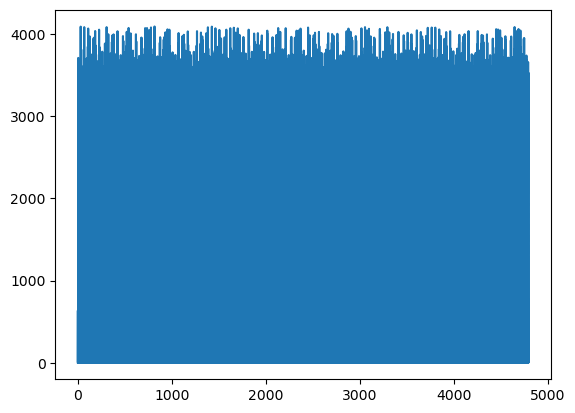

In [42]:
inst.send_scpi_cmd(':DIG:INIT OFF')
wav1 = np.zeros(4800, dtype=np.uint16)
inst.send_scpi_cmd(':DIG:DATA:TYPE FRAM')
inst.send_scpi_cmd(':DIG:DATA:SEL ALL')

resp = inst.send_scpi_query(':DIG:DATA:SIZE?')
print(resp)
rc = inst.read_binary_data(':DIG:DATA:READ?', wav1, 4800)
plt.plot(wav1)
plt.show()

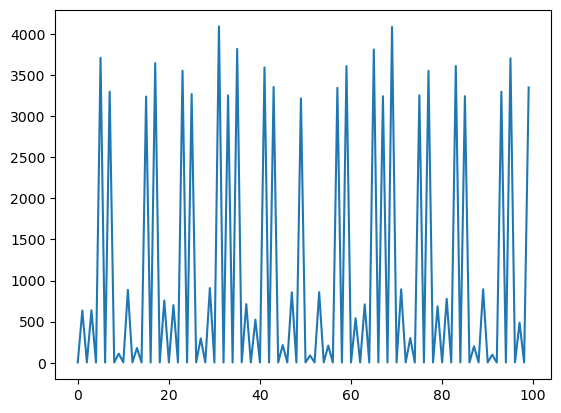

In [43]:
plt.plot(wav1[0:100])

In [112]:
2**12

4096

In [144]:
import numpy as np

# Assuming `samples` is already a NumPy array.
# Downsample the array (select every second element)
samples = wav1[0::2]  # Equivalent to MATLAB's `samples(1:2:length(samples))`

# Convert to int16 and subtract 16384
samples = np.int16(samples) - 16384

# Get the length of the array
wfmLength = len(samples)

# Split into I and Q components (taking every other element)
samplesI = samples[0:wfmLength:2].astype(np.float64)  # Take the real part
samplesQ = samples[1:wfmLength:2].astype(np.float64)  # Take the imaginary part




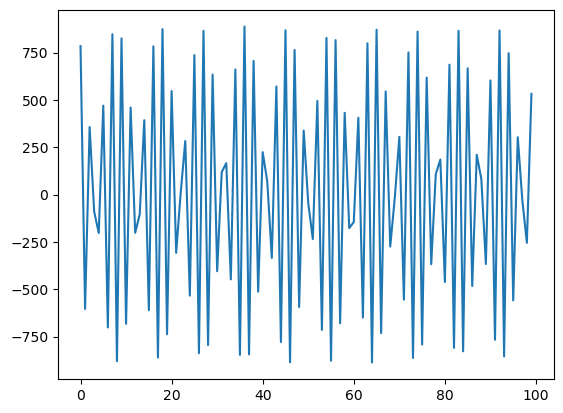

In [145]:
plt.plot(samplesI[0:100])